In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from   matplotlib import pyplot as plt
import scipy 

In [2]:
sample_signal = np.loadtxt('E:\OneDrive - KookminUNIV\KMU==Lab\MCSP==Research-Papers\SCI-02\Software\ProgrammingCodes\DataBase\data(mod)\\YJL_356_0313_2023.csv', delimiter=',')
bs = sample_signal[:,2]
gs = sample_signal[:,1]
rs = sample_signal[:,0]
sos  = scipy.signal.butter(N=2, Wn=8.0, btype='low',  fs=24, output='sos')  ### The sampling frequency of the digital system(‘fs’).second-order sections (‘sos’)
sos1 = scipy.signal.butter(N=2, Wn=0.5, btype='high', fs=24, output='sos')
fil_s_b = scipy.signal.sosfilt(sos, bs)[10:]  
fil_s_g = scipy.signal.sosfilt(sos, gs) 
fil_s_r = scipy.signal.sosfilt(sos, rs)[10:] 
fil_s_b1 = scipy.signal.sosfilt(sos1, fil_s_b)[110:] + np.mean(fil_s_b) 
fil_s_g1 = scipy.signal.sosfilt(sos1, fil_s_g) + np.mean(fil_s_g)   
fil_s_r1 = scipy.signal.sosfilt(sos1, fil_s_r)[110:] + np.mean(fil_s_r)
db= pd.DataFrame(fil_s_b1)
import os  
os.makedirs('E:\OneDrive - KookminUNIV\KMU==Lab\meeting report\csv files', exist_ok=True) 
db.to_csv('E:\OneDrive - KookminUNIV\KMU==Lab\meeting report\csv files\\YJL356_blue_bdr.csv')
dm= pd.DataFrame(fil_s_g1)
import os  
os.makedirs('E:\OneDrive - KookminUNIV\KMU==Lab\meeting report\csv files', exist_ok=True) 
dm.to_csv('E:\OneDrive - KookminUNIV\KMU==Lab\meeting report\csv files\\YJL356_green_bdr.csv')
dn= pd.DataFrame(fil_s_r1)
import os  
os.makedirs('E:\OneDrive - KookminUNIV\KMU==Lab\meeting report\csv files', exist_ok=True) 
dn.to_csv('E:\OneDrive - KookminUNIV\KMU==Lab\meeting report\csv files\\YJL356_red_bdr.csv')


In [3]:

df = pd.read_csv('E:\OneDrive - KookminUNIV\KMU==Lab\meeting report\csv files\\jhm245_green_bdr.csv', usecols=[1], skiprows=[0] , delimiter=',', header=None)
a=df.values
a

array([[ 9197.39717948],
       [12507.95475057],
       [11069.20234715],
       ...,
       [ 6436.01639703],
       [ 6434.42305418],
       [ 6429.9354045 ]])

In [6]:
def determine_ac_dc_from_PPG (csv_file, colorSignal, showFigure='True'):
    # Load the CSV file into a Pandas DataFrame
    df = pd.read_csv(csv_file, usecols=[1],skiprows=[0] , delimiter=',', header=None)

    # Extract the signal from the DataFrame
    Signal = df.values
    maxArray = []
    minArray = []
    p2pPanDF = pd.DataFrame({'index':[], 'value':[]})
    midValue = np.mean(Signal)
    maxValue = midValue
    minValue = midValue
    maxIndex = 0
    minIndex = 0
    
    for i in range(len(Signal)):
        nowValue = Signal[i]
        if (nowValue>midValue):
            if (minValue<midValue and minIndex>0):
                p2pPanDF = pd.concat([p2pPanDF, pd.DataFrame({'index':[minIndex], 'value':[minValue]})], ignore_index=True, sort=False)
                minArray = np.append(minArray, minValue)
                minValue = midValue
            if (nowValue>maxValue):
                maxValue = nowValue
                maxIndex = i
        if (nowValue<midValue):
            if (maxValue>midValue and maxIndex>0):
                p2pPanDF = pd.concat([p2pPanDF, pd.DataFrame({'index':[maxIndex], 'value':[maxValue]})], ignore_index=True, sort=False)
                maxArray = np.append(maxArray, maxValue)
                maxValue = midValue
            if (nowValue<minValue):
                minValue = nowValue
                minIndex = i

    ## Calculate AC and DC
    acSignal = np.mean(maxArray) - np.mean(minArray)
    dcSignal = np.mean(minArray)

    ## Show Figure
    if (showFigure=='True'):
        plt.rcParams.update(plt.rcParamsDefault)
        plt.rcParams['font.size'] = '9'
        plt.figure(figsize=(21, 3))
        plt.title(f'***Analyze AC and DC Characteristics in a PPG Signal*** \n AC={acSignal} and DC={dcSignal} \n Total Peaks={len(maxArray)}(mean={np.mean(maxArray)}) and Valley={len(minArray)}(mean={np.mean(minArray)})', y=1, loc='center')
        plt.xlabel('Sample Count')
        plt.ylabel(' ')
        for i in range(len(Signal)):
            plt.plot(i, midValue,          '.', color='k')
            plt.plot(i, np.mean(maxArray), '.', color='m')
            plt.plot(i, np.mean(minArray), '.', color='y')
        plt.plot(Signal, color=f'{colorSignal}')
        plt.plot(p2pPanDF.values[:,0], p2pPanDF.values[:,1], 'x', color='k')
        plt.grid(True)
        plt.show()

    return acSignal, dcSignal

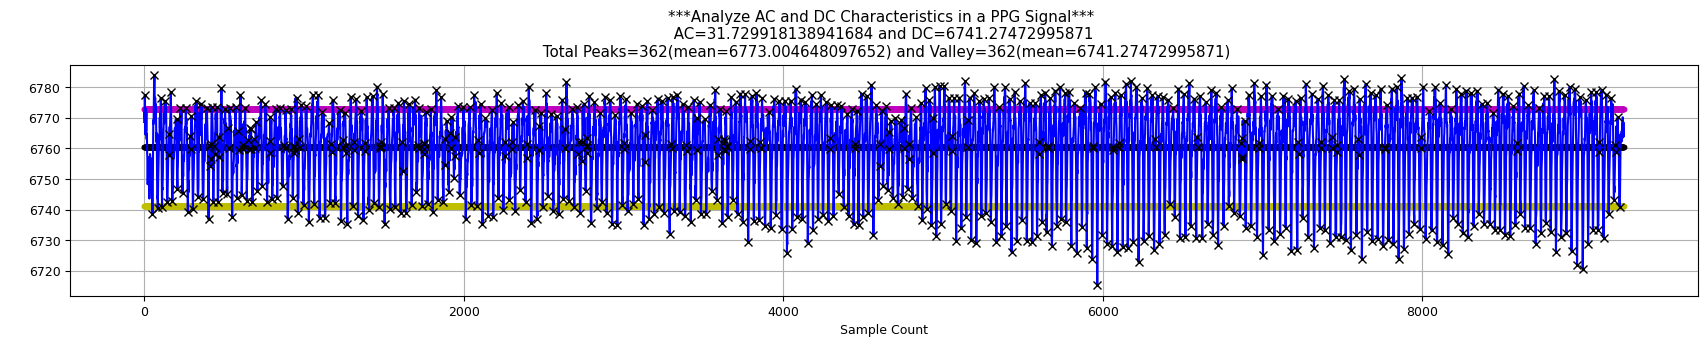

(31.729918138941684, 6741.27472995871)

In [7]:

ac, dc = determine_ac_dc_from_PPG('E:\OneDrive - KookminUNIV\KMU==Lab\meeting report\csv files\\jhm245_blue_bdr.csv', 'b', showFigure='True')
ac, dc


## Thresholding


In [9]:
def determine_ac_dc_from_PPG_v3(csv_file, colorSignal, ac_threshold, showFigure=False):
    # Load the CSV file into a Pandas DataFrame
    df = pd.read_csv(csv_file, usecols=[1],skiprows=[0] , delimiter=',', header=None)

    # Extract the signal from the DataFrame
    Signal = df.values
    maxArray = []
    minArray = []
    p2pPanDF = pd.DataFrame({'index': [], 'value': []})
    midValue = np.mean(Signal)
    maxValue = midValue
    minValue = midValue
    maxIndex = 0
    minIndex = 0

    for i in range(len(Signal)):
        nowValue = Signal[i]
        if nowValue > midValue:
            if minValue < midValue and minIndex > 0 and i - minIndex >= ac_threshold:
                p2pPanDF = pd.concat([p2pPanDF, pd.DataFrame({'index': [minIndex], 'value': [minValue]})], ignore_index=True,
                                     sort=False)
                minArray = np.append(minArray, minValue)
                minValue = midValue
            if nowValue > maxValue:
                maxValue = nowValue
                maxIndex = i
        if nowValue < midValue:
            if maxValue > midValue and maxIndex > 0 and i - maxIndex >= ac_threshold:
                p2pPanDF = pd.concat([p2pPanDF, pd.DataFrame({'index': [maxIndex], 'value': [maxValue]})], ignore_index=True,
                                     sort=False)
                maxArray = np.append(maxArray, maxValue)
                maxValue = midValue
            if nowValue < minValue:
                minValue = nowValue
                minIndex = i

    ## Calculate AC and DC
    acSignal = np.mean(maxArray) - np.mean(minArray)
    if acSignal < ac_threshold:
        return None, None

    dcSignal = np.mean(minArray)

    ## Show Figure
    if showFigure:
        plt.rcParams.update(plt.rcParamsDefault)
        plt.rcParams['font.size'] = '9'
        plt.figure(figsize=(21, 3))
        plt.title(
            f'***Analyze AC and DC Characteristics in a PPG Signal*** \n AC={acSignal} and DC={dcSignal} \n Total Peaks={len(maxArray)}(mean={np.mean(maxArray)}) and Valley={len(minArray)}(mean={np.mean(minArray)})',
            y=1, loc='center')
        plt.xlabel('Sample Count')
        plt.ylabel(' ')
        for i in range(len(Signal)):
            plt.plot(i, midValue, '.', color='k')
            plt.plot(i, np.mean(maxArray), '.', color='m')
            plt.plot(i, np.mean(minArray), '.', color='y')
        plt.plot(Signal, color=f'{colorSignal}')
        plt.plot(p2pPanDF.values[:, 0], p2pPanDF.values[:, 1], 'x', color='k')
        plt.grid(True)
        plt.show()

    return acSignal, dcSignal


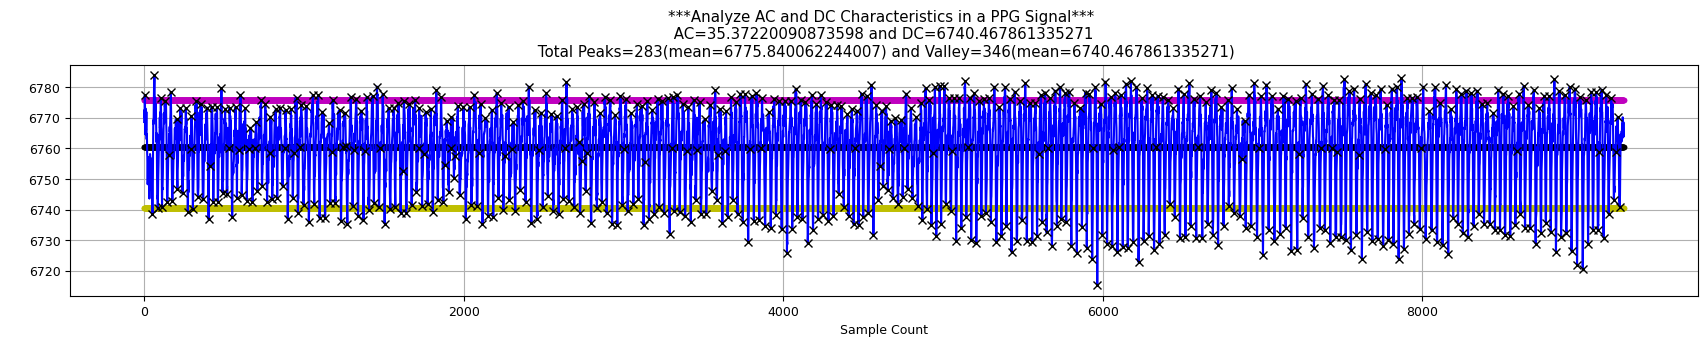

(35.37220090873598, 6740.467861335271)

In [10]:
ac, dc = determine_ac_dc_from_PPG_v3('E:\OneDrive - KookminUNIV\KMU==Lab\meeting report\csv files\\jhm245_blue_bdr.csv', 'b',ac_threshold=7, showFigure='True')
ac, dc